In [11]:
import numpy as np
import logging
import sys
from matplotlib import pyplot as plt
import torch
from math import atan2,degrees

%matplotlib inline
sys.path.append("../")


from aef.models.autoencoding_flow import TwoStepAutoencodingFlow
from aef.trainer import AutoencodingFlowTrainer, NumpyDataset
from aef.losses import nll, mse

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)



## Load data

In [3]:
latent_dims = np.load("../data/results/latent_dims_tth.npy")
mses = np.load("../data/results/mse_tth.npy")
nlls = np.load("../data/results/nll_tth.npy")

## Plot

In [9]:
#Label line with line2D label data
def labelLine(line,y,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    assert ydata[0] < y <  ydata[-1]

    #Find corresponding x co-ordinate and angle of the line
    ip = 1
    for i in range(len(ydata)):
        if y < ydata[i]:
            ip = i
            break

    x = xdata[ip-1] + (xdata[ip]-xdata[ip-1])*(y-ydata[ip-1])/(ydata[ip]-ydata[ip-1])
    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):

    ax = lines[0].axes
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)

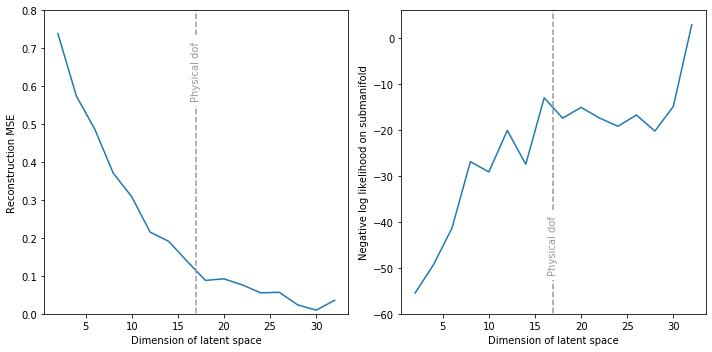

In [16]:
plt.figure(figsize=(10,5))

ax = plt.subplot(1,2,1)
plt.plot(latent_dims, mses)
plt.plot([17, 17], [-1000., 1000.], ls="--", c="0.6")
labelLine(line=plt.gca().get_lines()[-1], label="Physical dof", y=0.64)
plt.ylim(0.,0.8)
plt.xlabel("Dimension of latent space")
plt.ylabel("Reconstruction MSE")

ax = plt.subplot(1,2,2)
plt.plot(latent_dims, nlls)
plt.plot([17, 17], [-1000., 1000.], ls="--", c="0.6")
labelLine(line=plt.gca().get_lines()[-1], label="Physical dof", y=-45)
plt.ylim(-60,6)
plt.xlabel("Dimension of latent space")
plt.ylabel("Negative log likelihood on submanifold")

plt.tight_layout()
plt.savefig("../figures/scanning_latent_dim_tth.pdf")